In [1]:
%run __imports.ipynb

This tutorial will introduce you with the basics of Frenkel-Halsey-Hill and Derjaguin-Broekhoff-de Boer theories, adsorption integral equation, and its way to solve to extract a pore size distribution from a given reference (macroporous) and target (microporous) isotherms.


Frenkel-Halsey-Hill fit
======================

The Derjaguin-Broekhoff-de Boer theory states that chemical potential $\mu$ can be described by the following equation:
$$\mu = R_{\mathrm{g}} T \ln (p/p_0) = - \left ( \Pi + \frac{2 \gamma}{R - h} \right) V_{\mathrm{l}}$$

where $R_{\mathrm{g}}$ is the gas constant, $T$ is the temperature, $p/p_0$ is the relative pressure, $\Pi$ is the disjoining pressure, $\gamma$ is the surface tension, $R$ is the pore radius, $V_{\mathrm{l}}$ is the molar volume. The Frenkel-Halsey-Hill theory suggests fitting disjoining pressure $\Pi$ as
$$\Pi = \frac{R_{\mathrm{g}} T}{V_{\mathrm{l}}} \frac{k}{(h/h_0)^m}$$

where $k$ and $m$ are the unknown parameters, $h$ is the adsorbed film thickness, $h_0 = 1$ Angstrom is a constant. These $k$ and $m$ can be found easier considering an isotherm for a macroporous sample assuming $R$ is large, so that $\mu \approx - \Pi V_{\mathrm{l}}$, and therefore, the parameters can be found using linear regression over $\ln(-\ln(p/p_0))$ as a function of $\ln (h / h_0)$.

Let us consider a reference sample with an almost flat surface, and let us find $k$, $m$ parameters for the FHH theory that will be used for further mesoporous material analysis

In [2]:
data = np.genfromtxt("../data/maximov2019lang/sampleR.tsv", names=True)
pressure_ref = data["p_rel"]
density_ref = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
n2_csa = 0.162e-18  # cross-sectional area, m2
s_a = bet.surface_area(pressure_ref, density_ref, csa=n2_csa) * 1e3
model = dbdb.nitrogen(reference_s_a=s_a)
fhh_k, fhh_m = model.fhh_fit(pressure_ref, density_ref)

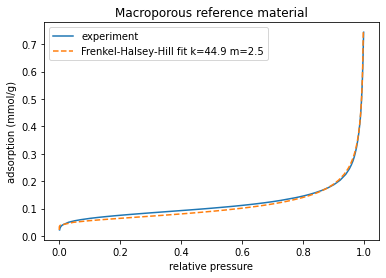

In [3]:
plt.plot(pressure_ref, density_ref, label="experiment")
plt.plot(
    model.relative_pressure_macropore(density_ref, fhh_k, fhh_m),
    density_ref,
    "--",
    label=f"Frenkel-Halsey-Hill fit k={fhh_k:.1f} m={fhh_m:.1f}",
)
plt.xlabel("relative pressure")
plt.ylabel("adsorption (mmol/g)")
plt.title("Macroporous reference material")
plt.legend()
plt.show()

Target mesoporous sample to analyze

In [4]:
data = np.genfromtxt("../data/maximov2019lang/sample2-des.tsv", names=True)
pressure_exp = data["p_rel"]
density_exp = data["Q_cm3_per_g_STP"]
density_exp = density_exp / np.max(density_exp)

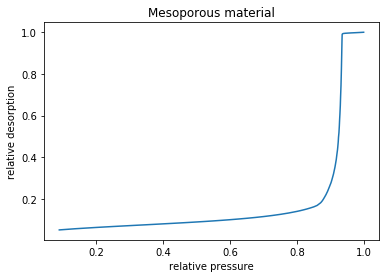

In [5]:
plt.plot(pressure_exp, density_exp)
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.title("Mesoporous material")
plt.show()

Isotherm kernel based on Derjaguin-Broekhoff-de Boer theory
====================================

Next, we aim to build the desorption isotherm kernel for a range of pore sizes

In [6]:
pore_sizes = np.arange(1, 202, 2)
kernel = model.kernel(pressure_exp, pore_sizes, fhh_k, fhh_m, is_ads_branch=False)

Corresponding isotherm relative density $n$ for different pore diameters $d$ and relative pressures $p/p_0$

In [7]:
df = pd.DataFrame(kernel)
df.columns = [f"d = {d} nm" for d in pore_sizes]
df.index = [f"p/p0 = {d:.2f}" for d in pressure_exp]
df

,d = 1 nm,d = 3 nm,d = 5 nm,d = 7 nm,d = 9 nm,...,d = 193 nm,d = 195 nm,d = 197 nm,d = 199 nm,d = 201 nm
p/p0 = 1.00,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 0.99,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 0.99,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 0.98,1.0,1.000000,1.000000,1.000000,1.000000,...,0.095667,0.094154,0.092694,0.091284,0.089922
p/p0 = 0.98,1.0,1.000000,1.000000,1.000000,1.000000,...,0.084957,0.083746,0.082572,0.081434,0.080329
...,...,...,...,...,...,...,...,...,...,...,...
p/p0 = 0.25,1.0,1.000000,0.461341,0.329956,0.257613,...,0.012269,0.012143,0.012020,0.011899,0.011781
p/p0 = 0.22,1.0,1.000000,0.444830,0.319260,0.249571,...,0.011916,0.011794,0.011674,0.011557,0.011442
p/p0 = 0.20,1.0,1.000000,0.428789,0.308653,0.241541,...,0.011559,0.011440,0.011324,0.011211,0.011099
p/p0 = 0.14,1.0,0.642304,0.389811,0.282132,0.221253,...,0.010636,0.010527,0.010420,0.010316,0.010213


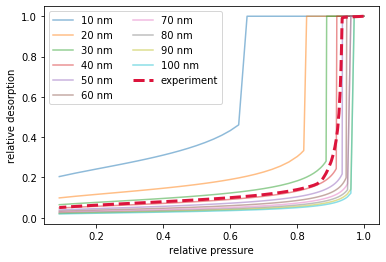

In [8]:
display_pores_sizes = pore_sizes if len(pore_sizes) < 5 else np.arange(10, 110, 10)
for d in display_pores_sizes:
    psz_idx = np.abs(pore_sizes - d).argmin()
    plt.plot(pressure_exp, kernel[:, psz_idx], "-", label=f"{d} nm", alpha=0.5)

plt.plot(pressure_exp, density_exp, label="experiment", ls="--", lw=3, color="crimson")
plt.legend(ncol=2)
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.show()

Solution of the integral equation
================================
Finally, we need to solve the adsorption integral equation by the NNLS method with Tikhonov (Ridge) regularization
$$n_{\mathrm{exp}}(p/p_0) = \int_{d_{\rm{min}}}^{d_{\rm{max}}} n_{\mathrm{kernel}}(p/p_0) \mathrm{PSD}(d) \mathrm{d}d = X \beta + \varepsilon$$
where $n_{\mathrm{exp}}$ is the experimental isotherm (given), $n_{\mathrm{kernel}}$ is the kernel, PSD($d$) is the unknown function, $d$ is the pore diameter, $d_{\rm{min}}$, $d_{\rm{max}}$ are the limits. $X \beta + \epsilon$ is the discrete form of the equation with kernel $X$ generated above, pore size distribution $\beta$ to find, and residual $\varepsilon$.

In [9]:
alpha = np.concatenate(([1e-7], np.linspace(0, 1e4, 1001)[1:]))
clf_nnls = RidgeNNLS(alphas=np.power(alpha, 2)).fit(kernel, density_exp, alpha=8)
psd = clf_nnls.coef_
solution = kernel @ psd

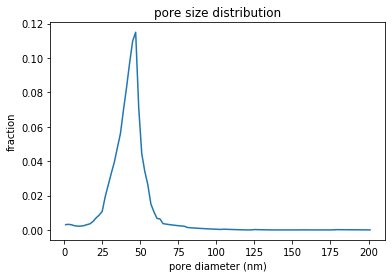

In [10]:
plt.plot(pore_sizes, psd)
plt.xlabel("pore diameter (nm)")
plt.ylabel("fraction")
plt.title("pore size distribution")
plt.show()

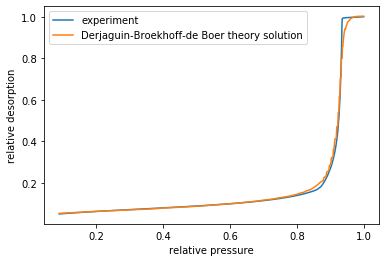

In [11]:
plt.plot(pressure_exp, density_exp, label="experiment")
plt.plot(pressure_exp, solution, label="Derjaguin-Broekhoff-de Boer theory solution")
plt.legend()
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.show()